In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
from datasets import load_dataset_builder
from datasets import load_dataset
import tensorflow_hub as hub
import pandas as pd
import torch
from src.modules.models.tdcnn import TDConvNetpp, WaveformEncoder, WaveformDecoder
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from src.datamodules.components.normalization import NormalizePeak

In [3]:
from torchaudio.compliance.kaldi import fbank

def compute_fbank_features(waveforms):
    fbank_features = [
        fbank(
            waveform.unsqueeze(0),
            htk_compat=True,
            sample_frequency=32_000,
            use_energy=False,
            window_type="hanning",
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10
        )
        for waveform in waveforms
    ]
    return torch.stack(fbank_features)

def pad_to_length(arr, target_length=80000):
    current_length = len(arr)
    if current_length == target_length:
        return arr
    # Calculate padding
    padding_length = target_length - current_length
    padded_array = np.pad(arr, (0, padding_length), 'constant', constant_values=0)
    return padded_array

In [4]:
builder = load_dataset_builder("DBD-research-group/BirdSet", "XCL")
hsn = load_dataset_builder("DBD-research-group/BirdSet", "HSN")
#idx = [builder.info.features["ebird_code"].str2int(name) for name in hsn.info.features["ebird_code"].names] # idx for 

In [5]:
encoder = WaveformEncoder(256, 256)
decoder = WaveformDecoder(256, 256)
model = TDConvNetpp(in_chan=256, n_src=4, n_repeats=4, encoder=encoder, decoder=decoder)

In [6]:
checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/xcm-normal-epoch059-loss_valid-11.4109-metric_valid11.4107.ckpt"
state_dict = torch.load(checkpoint, weights_only=False)
state_dict = {k[6:]:v for k,v in state_dict["state_dict"].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
%%capture
perch = hub.load('/tmp/tfhub_modules/8a404c0c0550c5e278ff2626da90f1cfdcb6f746')
cs = pd.read_csv("data/perch/label_updated.csv")
normalization = NormalizePeak(0.25)

idx = [cs[cs["ebird2021"] == i].index.values[0] for i in hsn.info.features["ebird_code"].names]

2024-11-17 17:45:42.469617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-17 17:45:42.471544: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
ds = load_dataset("DBD-research-group/BirdSet", "NBP_scape", cache_dir="data/NBP_scape")

In [24]:
data = ds["test_5s"][7]
print(data["ebird_code_multilabel"])
wave, sr = librosa.load(data["filepath"], sr=16000)
wave = pad_to_length(wave, target_length=80_000)
with torch.no_grad():
    masks, est_wave, weights = model(torch.tensor(wave).unsqueeze(0))
    est_wave = est_wave.squeeze(0)

[6, 14, 15]


In [28]:
preds = []
est_wave1 = torch.vstack([torch.tensor(wave).unsqueeze(0), est_wave])
for i in range(est_wave1.size(0)):
    w = est_wave1[i,:]
    w = librosa.resample(w.numpy(), orig_sr=16000, target_sr=32000)
    display(Audio(w, rate=32000, normalize=False))
    w = normalization(w)
    
    logits, _ = perch.infer_tf(np.expand_dims(w, 0))
    logits = torch.tensor(logits.numpy())[:,idx]
    p = torch.sigmoid(logits)
    # print("Correct confidence", p[:,data["ebird_code_multilabel"]].flatten())
    # print("Biggest pred:", cs.iloc[idx[p.numpy().argmax()]].values[0], p.max())
    # print("Correct Label:", hsn.info.features["ebird_code"].int2str(data["ebird_code_multilabel"]))
    # print("-"*50)

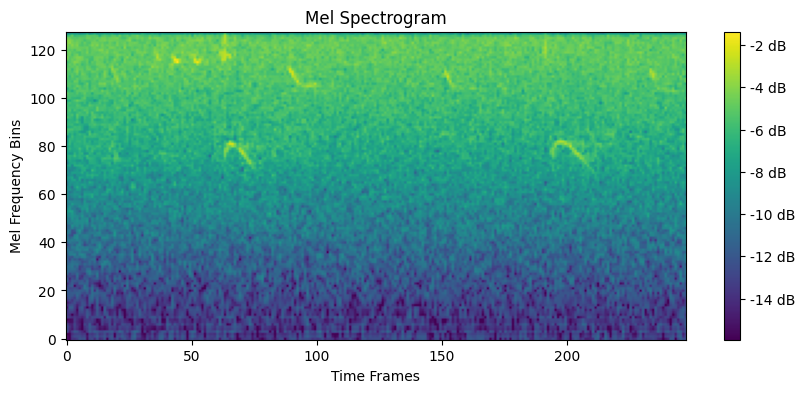

In [26]:
fbank_features = compute_fbank_features(est_wave1)
plt.figure(figsize=(10, 4))
plt.imshow(fbank_features[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')
plt.show()

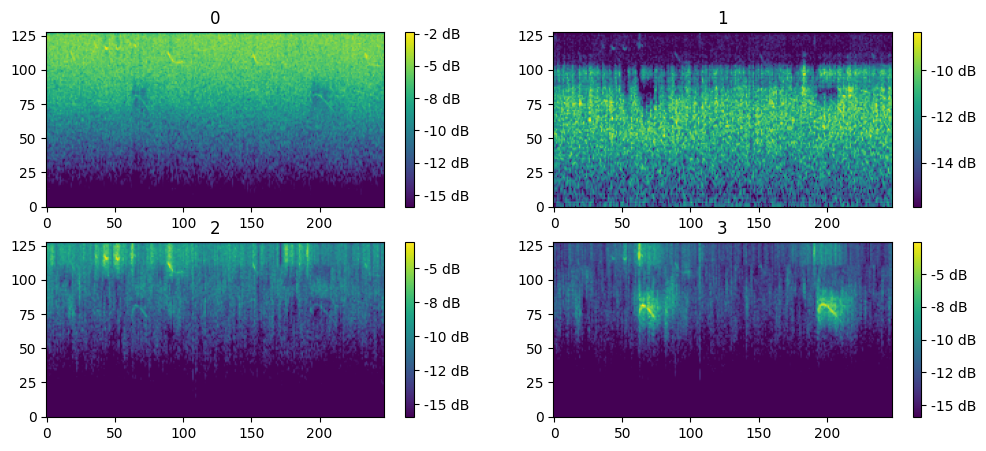

In [27]:
#fig, axes = plt.subplots(2, 2, figsize=(16, 8))
#axes = axes.flatten()
plt.figure(figsize=(12, 5))
for i in range(est_wave.shape[0]):
    plt.subplot(2, 2, i+1)
    plt.imshow(fbank_features[i+1].T, aspect='auto', origin='lower')
    plt.title(f"{i}")
    plt.colorbar(format='%+2.0f dB')
#plt.legend()
plt.show()

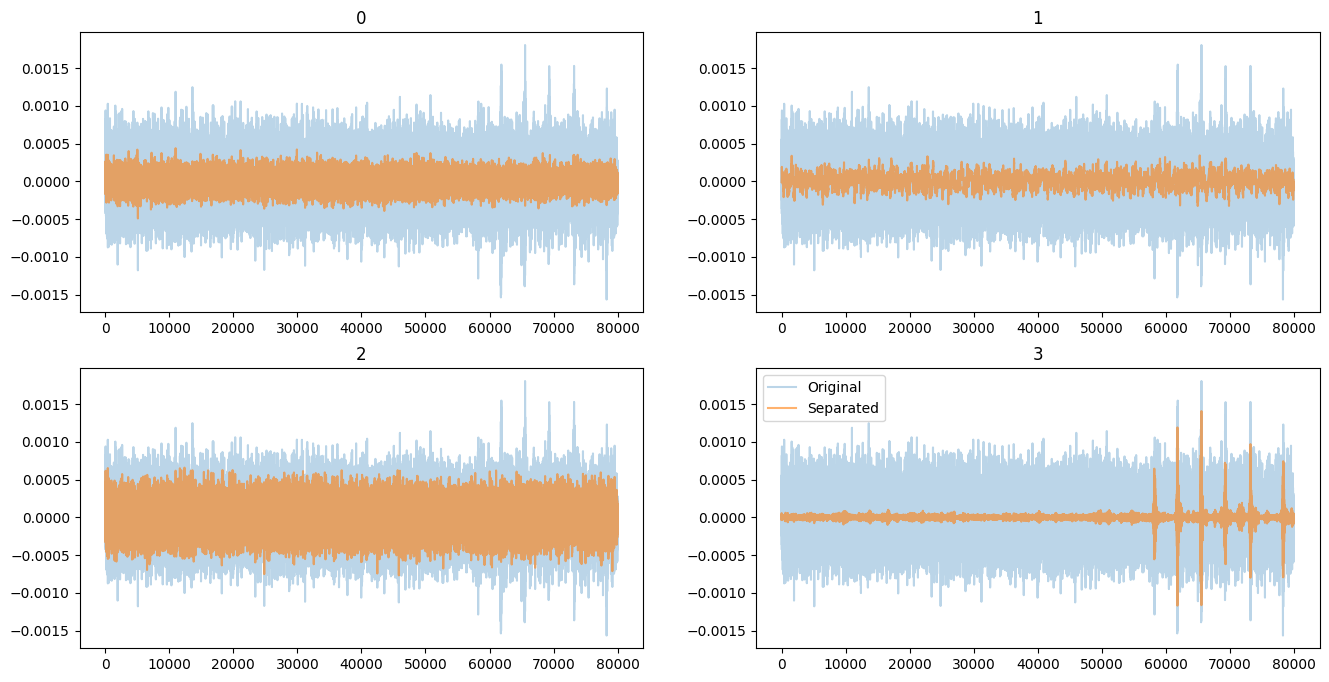

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()
for i in range(est_wave.shape[0]):
    axes[i].plot(wave.flatten(), alpha=0.3, label="Original")
    axes[i].plot(est_wave[i].flatten(), alpha=0.6, label="Separated")
    axes[i].set_title(f"{i}")
axes[-1].legend()
plt.show()